In [3]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

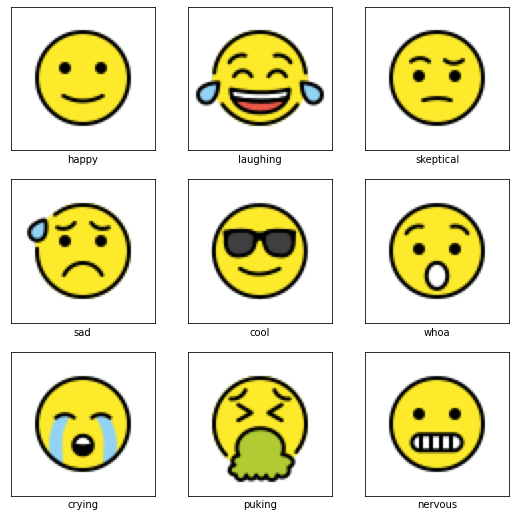

In [4]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

for i, ax in enumerate(axes.ravel()):
  ax.imshow(plt.imread(os.path.join('emoji', emojis[i]['file'])))
  ax.set_xlabel(emojis[i]['name'])
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

In [5]:
for class_id, values in emojis.items():
  png_file = Image.open(os.path.join('emoji', values['file'])).convert('RGBA')
  png_file.load()
  new_file = Image.new("RGB", png_file.size, (255, 255, 255))
  new_file.paste(png_file, mask=png_file.split()[3])
  emojis[class_id]['image'] = new_file

In [6]:
def create_example():
  class_id = np.random.randint(0, 9)
  image = np.ones((144, 144, 3)) * 255
  row = np.random.randint(0, 72)
  col = np.random.randint(0, 72)
  image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
  return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

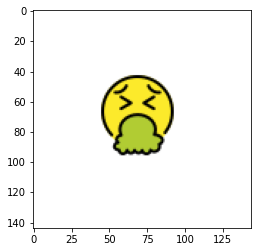

In [7]:
image, class_id, row, col = create_example()
plt.imshow(image)

In [8]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
  if norm:
    image *= 255.
    image = image.astype('uint8')
  image = Image.fromarray(image)
  draw = ImageDraw.Draw(image)
  
  row, col = gt_coords
  row *= 144
  col *= 144
  draw.rectangle((col, row, col + 52, row + 52), outline='green', width=3)
  
  if len(pred_coords) == 2:
    row, col = pred_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col + 52, row + 52), outline='red', width=3)
  return image

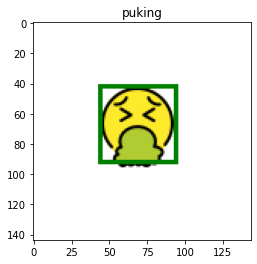

In [9]:
image = plot_bounding_box(image, (row, col))
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

In [10]:
def data_generator(batch_size=16):
  while True:
    x_batch = np.zeros((batch_size, 144, 144, 3))
    y_batch = np.zeros((batch_size, 9))
    bbox_batch = np.zeros((batch_size, 2))
    
    for i in range(0, batch_size):
      image, class_id, row, col = create_example()
      x_batch[i] = image / 255.
      y_batch[i, class_id] = 1.0
      bbox_batch[i] = np.array([row, col])
    yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

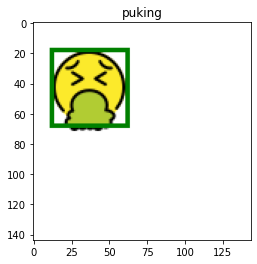

In [11]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

In [12]:
input = Input(shape=(144, 144, 3), name='image')

x = input

for i in range(5):
  n_filters = 2**(4+i)
  x = Conv2D(n_filters, 3, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 71, 71, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
class IoU(tf.keras.metrics.Metric):
  def __init__(self, **kwargs):
    super(IoU, self).__init__(**kwargs)
    
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
  
  def update_state(self, y_true, y_pred, sample_weight=None):
    def get_box(y):
      rows, cols = y[:, 0], y[:, 1]
      rows, cols = rows * 144, cols * 144
      y1, y2 = rows, rows + 52
      x1, x2 = cols, cols + 52
      return x1, y1, x2, y2
                                                              
    def get_area(x1, y1, x2, y2):
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
                                                                            
    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)
    
    i_x1 = tf.maximum(gt_x1, p_x1)
    i_y1 = tf.maximum(gt_y1, p_y1)
    i_x2 = tf.minimum(gt_x2, p_x2)
    i_y2 = tf.minimum(gt_y2, p_y2)
    
    i_area = get_area(i_x1, i_y1, i_x2, i_y2)
    u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area
    
    iou = tf.math.divide(i_area, u_area)
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))
    self.iou = tf.math.divide(self.total_iou, self.num_ex)

  def result(self):
    return self.iou
                                                                                                                                      
  def reset_state(self):
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    }
)

In [15]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x = example['image']
  y = label['class_out']
  box = label['box_out']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  gt_coords = box[0]
  pred_class = np.argmax(pred_y[0])
  image = x[0]

  gt = emojis[np.argmax(y[0])]['name']
  pred_class_name = emojis[pred_class]['name']

  image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
  color = 'green' if gt == pred_class_name else 'red'
  plt.imshow(image)
  plt.xlabel(f'Prediction: {pred_class_name}', color=color)
  plt.ylabel(f'GT: {gt}', color=color)

In [16]:
def test(model):
  test_datagen = data_generator(1)

  plt.figure(figsize=(16, 4))
  for i in range(6):
    plt.subplot(1, 6, i+1)
    test_model(model, test_datagen)
  plt.show()

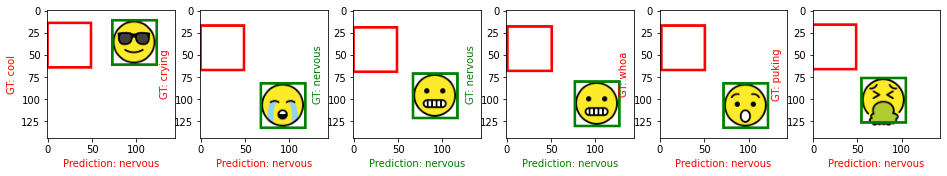

In [17]:
test(model)

In [18]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

Epoch 1/50
500/500 [==============================] - 10s 17ms/step - loss: 2.4042 - class_out_loss: 1.4456 - box_out_loss: 0.9586 - class_out_accuracy: 0.5207 - box_out_iou: 0.0936


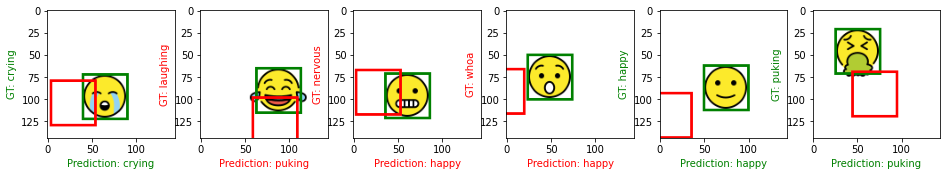

Epoch 2/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0450 - class_out_loss: 0.0113 - box_out_loss: 0.0337 - class_out_accuracy: 0.9997 - box_out_iou: 0.2804


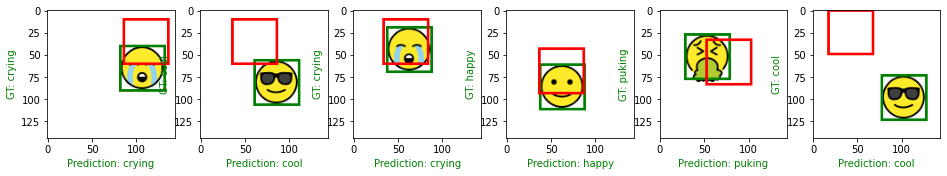

Epoch 3/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0160 - class_out_loss: 0.0033 - box_out_loss: 0.0128 - class_out_accuracy: 1.0000 - box_out_iou: 0.4310


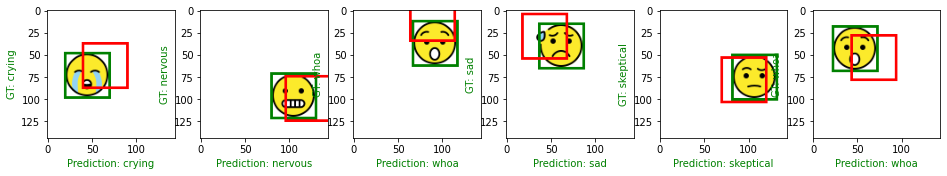

Epoch 4/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0097 - class_out_loss: 0.0018 - box_out_loss: 0.0078 - class_out_accuracy: 1.0000 - box_out_iou: 0.5094


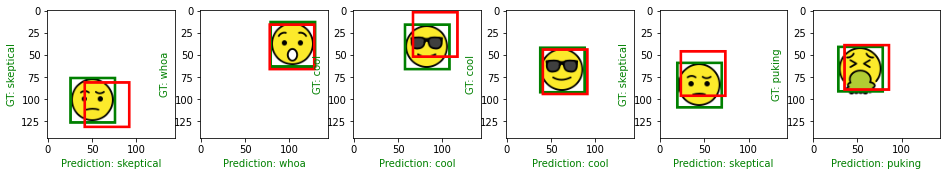

Epoch 5/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0042 - class_out_loss: 0.0011 - box_out_loss: 0.0031 - class_out_accuracy: 1.0000 - box_out_iou: 0.6412


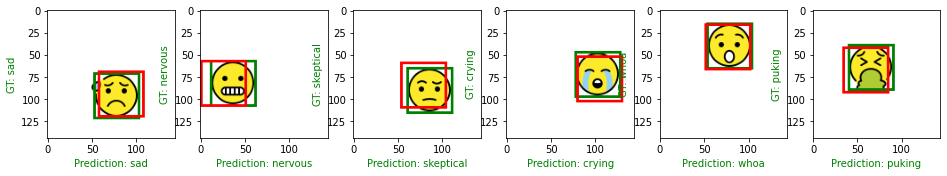

Epoch 6/50
500/500 [==============================] - 8s 17ms/step - loss: 0.0033 - class_out_loss: 7.3245e-04 - box_out_loss: 0.0026 - class_out_accuracy: 1.0000 - box_out_iou: 0.6692


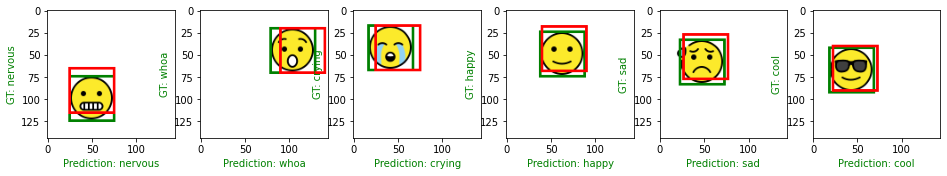

Epoch 7/50
500/500 [==============================] - 8s 16ms/step - loss: 0.0031 - class_out_loss: 6.8576e-04 - box_out_loss: 0.0024 - class_out_accuracy: 1.0000 - box_out_iou: 0.6757


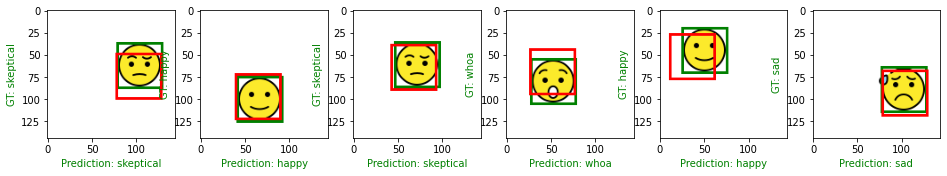

Epoch 8/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0028 - class_out_loss: 5.8285e-04 - box_out_loss: 0.0022 - class_out_accuracy: 1.0000 - box_out_iou: 0.6879


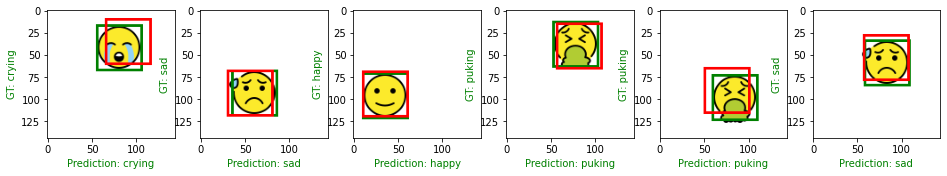

Epoch 9/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0025 - class_out_loss: 4.1286e-04 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - box_out_iou: 0.6960


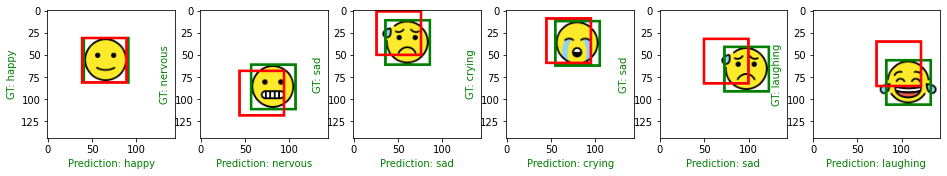

Epoch 10/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0019 - class_out_loss: 3.9062e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7339


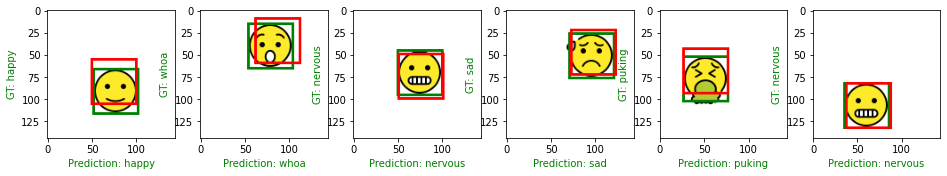

Epoch 11/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0016 - class_out_loss: 3.1677e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7448


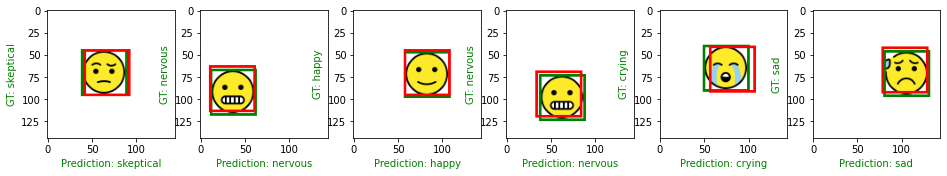

Epoch 12/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0018 - class_out_loss: 5.2507e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7461


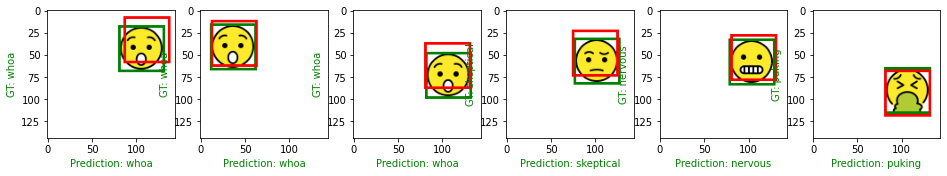

Epoch 13/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0016 - class_out_loss: 2.9882e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7466


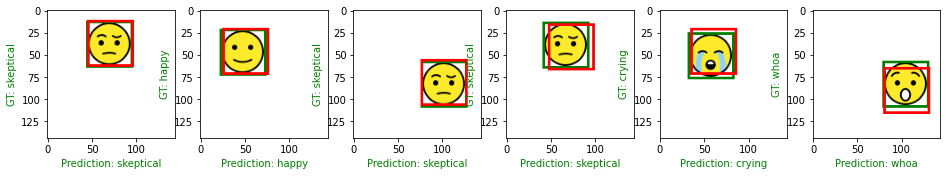

Epoch 14/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0015 - class_out_loss: 3.0515e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7531


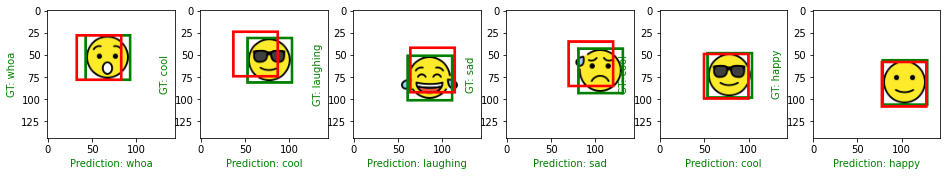

Epoch 15/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0015 - class_out_loss: 3.1347e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7596


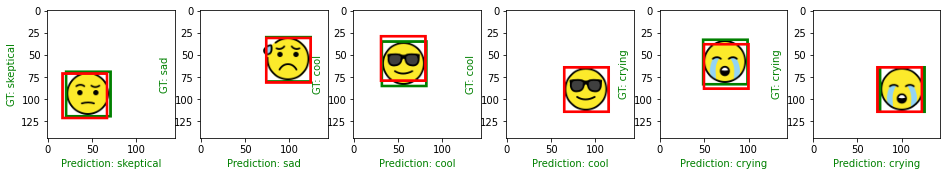

Epoch 16/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 2.5175e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7669


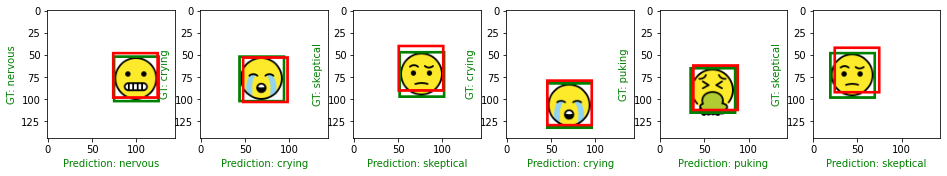

Epoch 17/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 3.2380e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7649


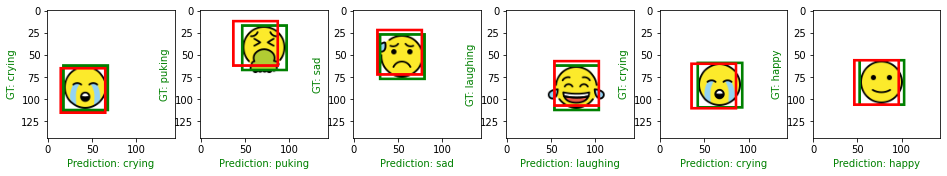

Epoch 18/50
500/500 [==============================] - 10s 19ms/step - loss: 0.0013 - class_out_loss: 2.4034e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7679


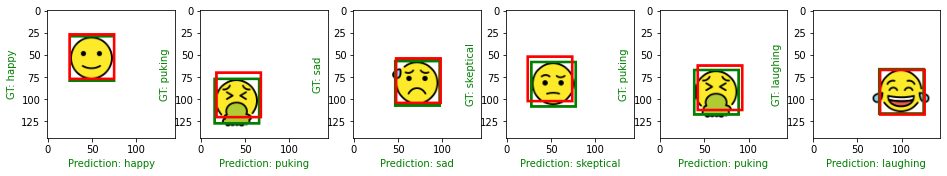

Epoch 19/50
500/500 [==============================] - 10s 19ms/step - loss: 0.0012 - class_out_loss: 2.2258e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7714


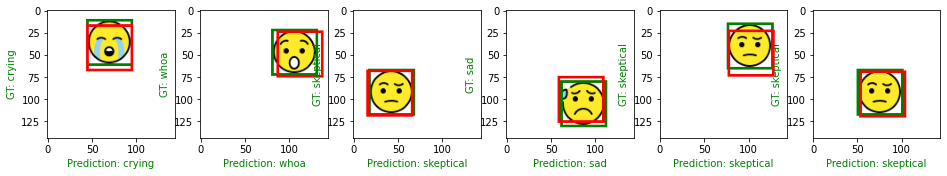

Epoch 20/50
500/500 [==============================] - 9s 19ms/step - loss: 0.0012 - class_out_loss: 1.9252e-04 - box_out_loss: 9.5967e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7751


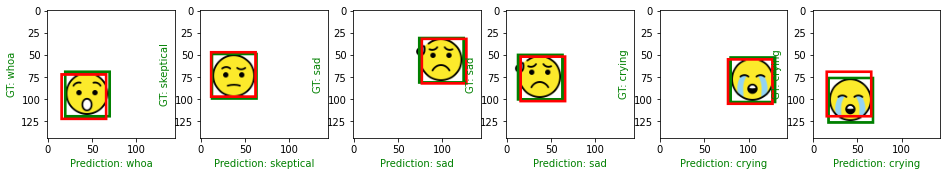

Epoch 21/50
500/500 [==============================] - 9s 19ms/step - loss: 0.0012 - class_out_loss: 2.0809e-04 - box_out_loss: 9.6095e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7758


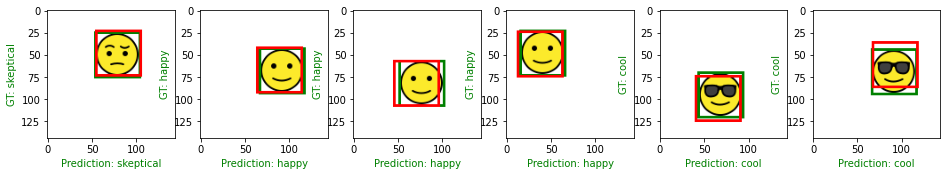

Epoch 22/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0011 - class_out_loss: 2.3275e-04 - box_out_loss: 9.1417e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7802


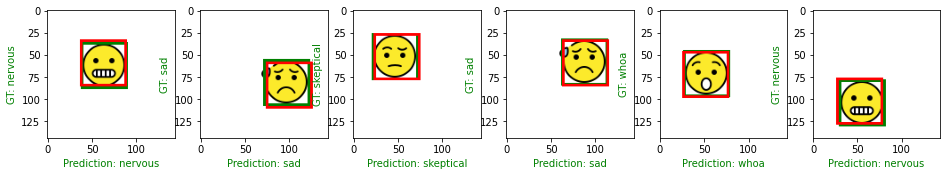

Epoch 23/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0011 - class_out_loss: 2.0804e-04 - box_out_loss: 9.2107e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7791


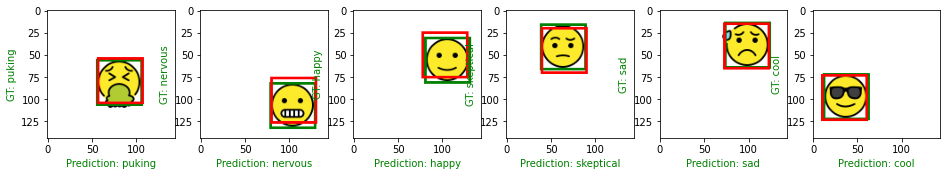

Epoch 24/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0012 - class_out_loss: 2.2192e-04 - box_out_loss: 9.4424e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7779


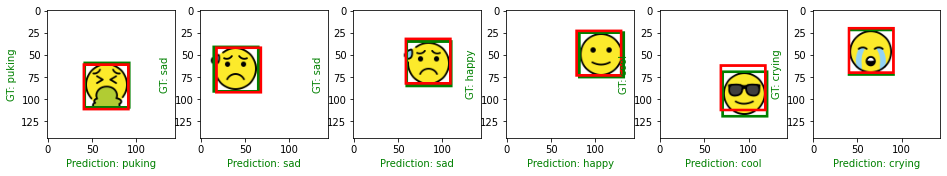

Epoch 25/50
500/500 [==============================] - 10s 20ms/step - loss: 0.0012 - class_out_loss: 2.2367e-04 - box_out_loss: 9.4784e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7774


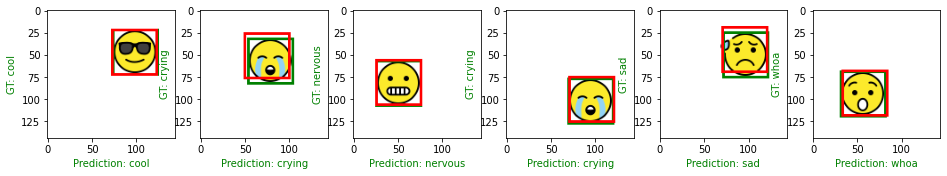

Epoch 26/50
500/500 [==============================] - 10s 20ms/step - loss: 0.0012 - class_out_loss: 2.2852e-04 - box_out_loss: 9.2257e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7806


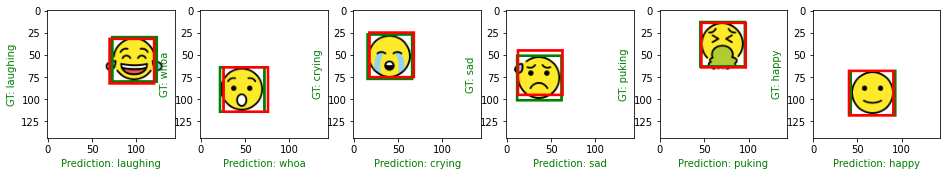

Epoch 27/50
500/500 [==============================] - 10s 20ms/step - loss: 0.0011 - class_out_loss: 2.0149e-04 - box_out_loss: 9.0573e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7833


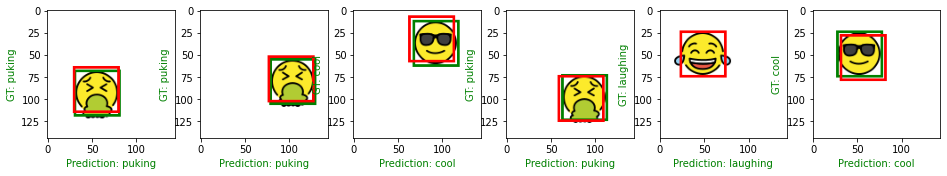

Epoch 28/50
500/500 [==============================] - 10s 20ms/step - loss: 0.0012 - class_out_loss: 2.3749e-04 - box_out_loss: 9.2151e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7810


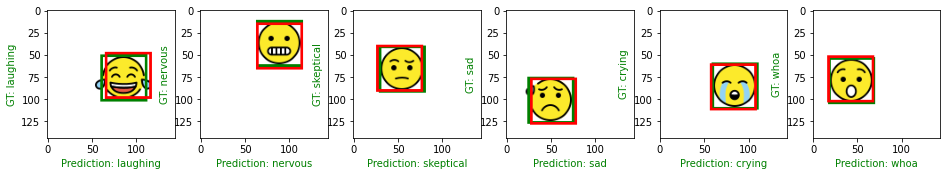

Epoch 29/50
500/500 [==============================] - 10s 20ms/step - loss: 0.0011 - class_out_loss: 2.2269e-04 - box_out_loss: 9.1457e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7808


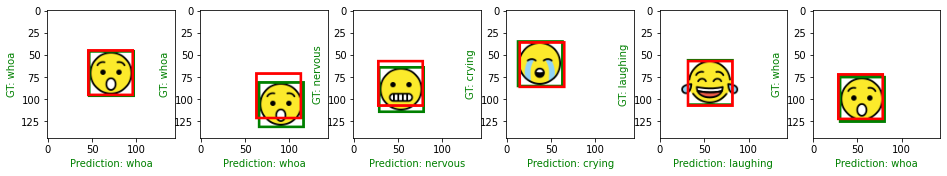

Epoch 30/50
500/500 [==============================] - 10s 20ms/step - loss: 0.0012 - class_out_loss: 2.3490e-04 - box_out_loss: 9.1664e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7812


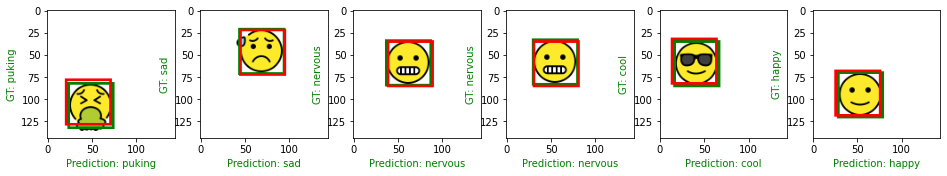

Epoch 31/50
500/500 [==============================] - 10s 20ms/step - loss: 0.0011 - class_out_loss: 2.3872e-04 - box_out_loss: 8.9754e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7816


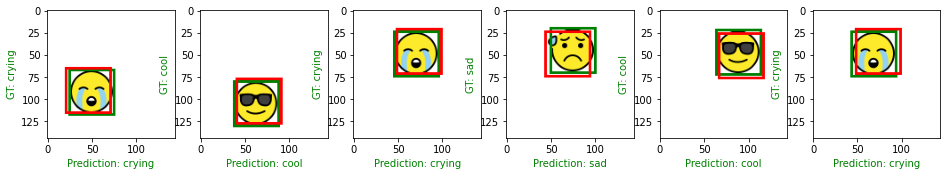

In [19]:
def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)

_ = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
               ShowTestImages(),
               tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
               ]
)